# Generate Images with Stable Diffusion
Use this notebook to create images of various scenes for any subject you prefer. We use Azure OpenAI to create scene descriptions based on your subject.

Example subject: __"animal"__ leads to scene discriptions like the following:  
   
"Full shot raw photo of a majestic white tiger lounging on a rock ledge in a lush green forest setting"  
"Wide angle photo of a playful group of dolphins leaping in the ocean waves with a sunlit horizon"  
"Wide shot raw photo of a flock of birds taking flight over a serene beach during sunrise"  
...

We are using these scene descriptions as input for text prompts to generate images with Stable Diffusion and Realistic Vision models. This way, you can easily generate hndreds of images of specific subject clusters (e.g., "animal", "man", "woman") as input for the image search demo scenarios of this repository.

Use the `image_classes` dictionary below to specify, the subject classes, number of images, model and other parameters based on your preferences.

## Setup

In [1]:
import time
import os
import openai
import sys
sys.path.insert(0, '..')

import shutil
import matplotlib.pyplot as plt
from PIL import Image

from diffusers import StableDiffusionPipeline, AutoencoderKL, DPMSolverMultistepScheduler
import torch
from IPython.display import display

from utils import show_images

In [2]:
openai.api_type = "azure"
openai.api_base = os.getenv("AOAI_ENDPOINT")
openai.api_version = "2023-03-15-preview"
openai.api_key = os.getenv("AOAI_API_KEY")

In [3]:
def generate_prompt(subject):

    """
    Generate a photo scene description based on a subject.
    Note that we are generating two calls to the AOAI API to avoid frequent generations of the same scene
    """
    
    system_prompt = """\
    You create a creative but concise text prompt of one to two sentences to describe a photo scene based on a subject that the user provides.
    The prompt should include photography aspects like the subject, the scene, lightning and other photo shooting related aspects
    Be very creative and diverse and add further details. For example if the provided subject is "animal", select a species.
    Always start the prompt with RAW photo of
    """

    messages = [{"role":"system","content": system_prompt}]
    messages.append({"role":"user","content": subject})  

    response = openai.ChatCompletion.create(
    engine="gpt-4",
    messages = messages,
    temperature=1,
    max_tokens=800,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    stop=None)

    initial_response = response['choices'][0]['message']['content']

    messages.append({"role":"assistant","content": initial_response})  
    messages.append({"role":"user","content": subject})  

    response = openai.ChatCompletion.create(
    engine="gpt-4",
    messages = messages,
    temperature=1,
    max_tokens=800,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    stop=None)

    second_response = response['choices'][0]['message']['content']

    return(second_response)

def generate_images(pipe, prompt, suffix, negative_prompt, num_images=1):

    """Generate images based on Diffusers pipeline, scene prompt, suffic, and negative prompt"""
  
    images = pipe(prompt=prompt + suffix,
                negative_prompt=negative_prompt,
                height=512,
                width=768,
                guidance_scale=7.5,
                num_inference_steps=50,
                num_images_per_prompt=num_images,
                ).images
    
    return images

## Initialize Stable Diffusion Pipelines

In [ ]:
# Realistic Vision 2.0 for images of people
rv20_pipe = StableDiffusionPipeline.from_pretrained(
    "SG161222/Realistic_Vision_V2.0",
    # custom_pipeline= 'lpw_stable_diffusion',
    torch_dtype=torch.float16,
    ).to('cuda')

# Stable Diffusion 2.1 for images of other subjects (e.g., animals)
sd21_pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    custom_pipeline= 'lpw_stable_diffusion',
    torch_dtype= torch.float16,
    )

sd21_pipe.scheduler = DPMSolverMultistepScheduler.from_config(sd21_pipe.scheduler.config)
sd21_pipe.to('cuda')

## Specify classes based on desired subjects
Specify your desired image clusters (e.g., "man", "woman", "children"), the text2image vision model, number of samples, suffix to add to the scene description, and the negative prompt.   

In [5]:
root = './testimages' # root folder for generated images

rv20_suffix = ", (high detailed skin:1.2), 8k uhd, dslr, high quality, film grain, real-world, unedited, photorealistic, Fujifilm XT3, natural, authentic"
rv20_negative_prompt = '(semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), text, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck'

sd21_suffix = ", National Geographic Wildlife photo of the year, dslr, 8K UHD"
sd21_negative_prompt = 'deformed, disfigured, underexposed, overexposed'

image_classes = [
    {'classname': 'man', 'pipe' : rv20_pipe, 'samples' : 9, 'suffix' : rv20_suffix, 'negative_prompt' : rv20_negative_prompt },
    {'classname': 'woman', 'pipe' : rv20_pipe, 'samples' : 9, 'suffix' : rv20_suffix, 'negative_prompt' : rv20_negative_prompt },
    {'classname': 'children', 'pipe' : rv20_pipe, 'samples' : 9, 'suffix' : rv20_suffix, 'negative_prompt' : rv20_negative_prompt },
    {'classname': 'animal', 'pipe' : sd21_pipe, 'samples' : 9, 'suffix' : sd21_suffix, 'negative_prompt' : sd21_negative_prompt },
]

## Generate images

In [ ]:
for classname in image_classes:

    image_path = os.path.join(root, classname['classname'])
    
    # delete folder if it exists. Create empty folder in any case
    if os.path.exists(image_path):
        shutil.rmtree(image_path)
    os.makedirs(image_path)

    for image_idx in range(classname['samples']):
        try:
            prompt = generate_prompt(classname['classname'])
        except Exception as e:
            # Try again after 30s to work around rate limit error
            time.sleep(30)
            prompt = generate_prompt(classname['classname'])
        print(prompt)

        image = generate_images(
            pipe= classname['pipe'],
            prompt= prompt,
            suffix= classname['suffix'],
            negative_prompt= classname['negative_prompt'],
            )[0]

        image.save(os.path.join(image_path, f"image-{image_idx:03}.png"))

man:


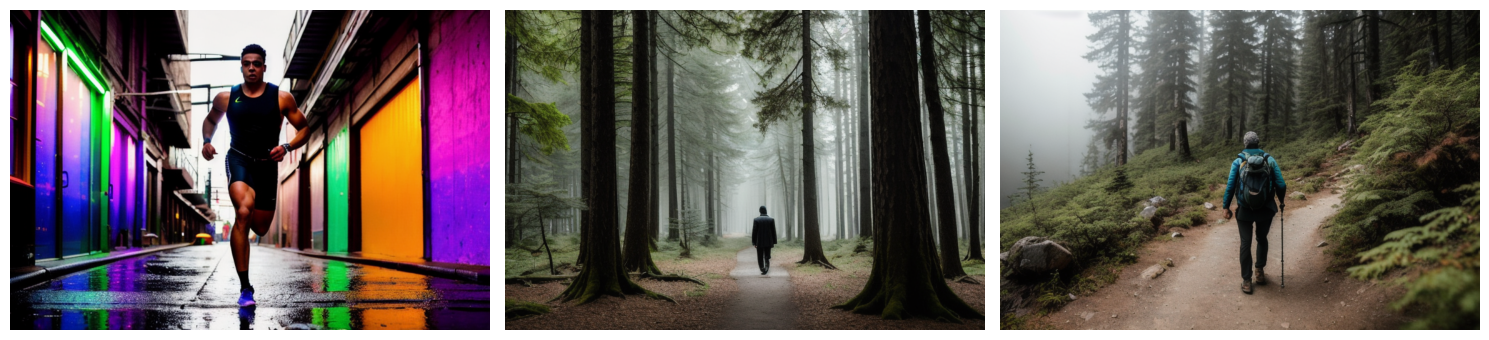

woman:


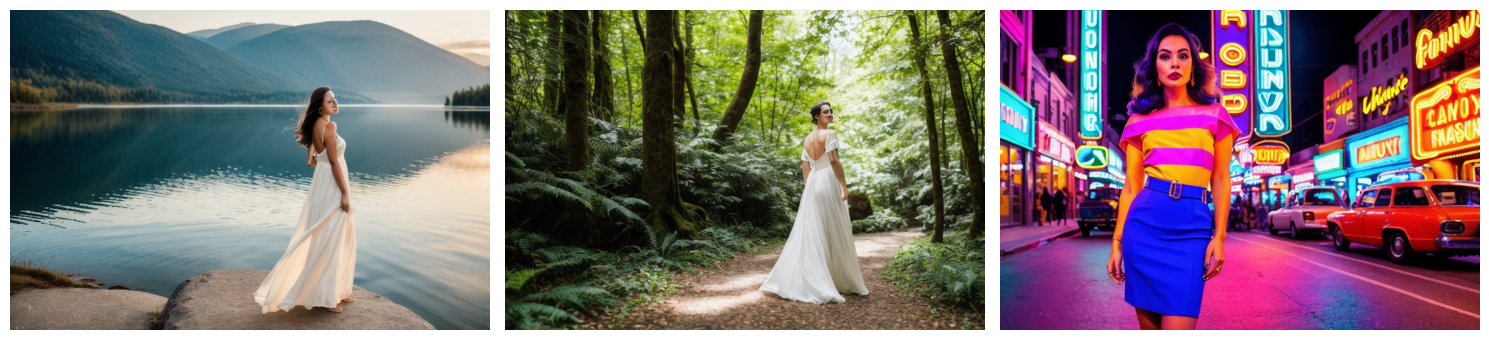

children:


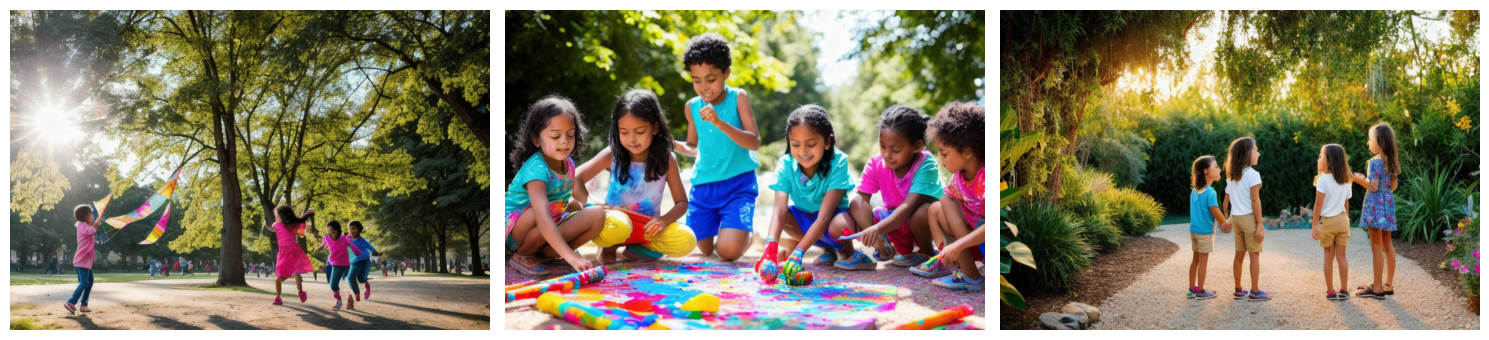

animal:


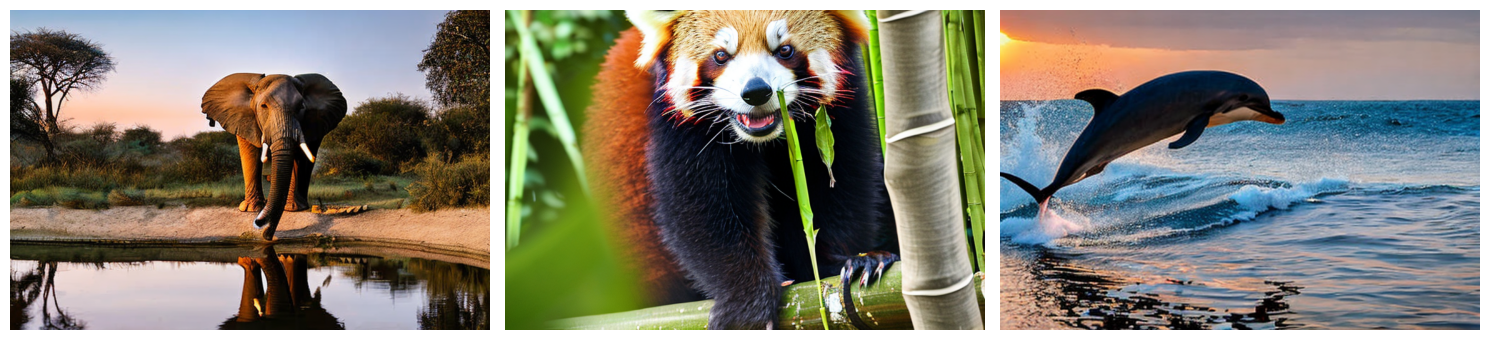

In [8]:
samples_per_class = 3

for classname in image_classes:
    print(f"{classname['classname']}:")
    image_path = os.path.join(root, classname['classname'])
    image_list = [os.path.join(image_path, image) for image in os.listdir(image_path) if image.endswith('.png')]

    show_images(images=image_list[:samples_per_class], cols=3, source='local')